In [1]:
#Please execute this cell
import jupman;
jupman.mem_limit()

Free mem: 2125 MB  Limiting to: 1062 MB


In [2]:
def mem_limit(MB=None):
    import os
    if os.name == 'nt':
        print('WARNING: limiting memory on Windows is not supported')
        return
    
    import resource
    with open('/proc/meminfo', 'r') as mem:
        free_memory = 0
        for i in mem:
            sline = i.split()            
            if str(sline[0]) == 'MemAvailable:':
                free_memory = int(sline[1])               
                break     
        if sline[2] != 'kB':
            raise Exception('Unrecognized memory unit:', sline[2])
        soft, hard = resource.getrlimit(resource.RLIMIT_AS)
        if not MB:                    
            MB = (free_memory // 1024) // 2  
        print('Free mem:', free_memory//1024, 'MB', 
              ' Limiting to:', MB, 'MB')
        resource.setrlimit(resource.RLIMIT_AS, (MB *1024 * 1024, hard))

mem_limit()

Free mem: 2130 MB  Limiting to: 1065 MB


# Midterm sim -  Fri 05, Nov 2021 EXERCISES

**Scientific Programming - Data Science Master @ University of Trento**

**THIS IS ONLY A SIMULATION: YOU EARN NOTHING, YOU LOSE NOTHING**

<!-- ## [Download exercises and solutions](_static/generated/sciprog-ds-2021-11-05-exam.zip) 

**Fri 05, Nov 2021**: Published [exam solutions](exams/2021-11-05/solutions/exam-2021-11-05-sol.ipynb)
-->

## Part A - Terence Hill and Bud Spencer movies

Among the greatest gifts of Italy to the world we can certainly count Terence Hill and Bud Spencer movies. 

We took their movies data from [Wikidata](https://wikidata.org/), a project by the Wikimedia foundation which aims to store only machine-readable data, like numbers, strings, and so on interlinked with many references. Each entity in Wikidata has an identifier, for example Terence Hill is the [entity Q243430](http://www.wikidata.org/entity/Q243430) and Bud Spencer is [Q221074](http://www.wikidata.org/entity/Q221074).

<!--Wikidata can be queried using the SPARQL language: the data was obtained with [this query](https://query.wikidata.org/#SELECT%20%3Fstar%20%3FstarLabel%20%3Fitem%20%3FitemLabel%20%28MIN%28%3Fdate%29%20AS%20%3FfirstReleased%29%0AWHERE%20%7B%0A%20%20%3Fitem%20wdt%3AP161%20%3Fstar%3B%0A%20%20%20%20%20%20%20%20wdt%3AP577%20%3Fdate.%0A%20%20%20%20%0A%20%20FILTER%20%28%3Fstar%20%3D%20wd%3AQ221074%20%7C%7C%20%3Fstar%20%3D%20wd%3AQ243430%29%20%20%0A%20%20%20%20%20%20%20%20%20%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22.%20%7D%0A%20%20OPTIONAL%20%7B%20%3Fitem%20wdt%3AP18%20%3F_image.%20%7D%0A%7D%20GROUP%20BY%20%3Fstar%20%3FstarLabel%20%3Fitem%20%3FitemLabel%20%3F_image%0AORDER%20BY%20%28%3Fdate%29) repeated for several languages, and downloaded in CSV format (among the many which can be chosen). <!--Even if not necessary for the purposes of the exercise, you are invited to play a bit with the interface, like trying different visualizations (i.e. try select map in the middle-left corner) - or see other examples-->


You are given some CSVs of movies, all having names ending in `-LG.csv`, where LG can be a language tag like `it`, `en`, `de`, `es`... They mostly contain the same data except for the movie labels which are in the corresponding language. The final goal will be displaying the network of movies and put in evidence the ones co-starring the famous duo. 

Each file row contains info about a single actor starring in a movie. Multiple lines with same movie id will mean multiple actors are co-starring. We can see an excerpt of **first four** lines of english version: notice second movie has id [Q180638](http://www.wikidata.org/entity/Q180638) and is co-starred by both Bud Spencer and Terence Hill

star,starLabel,movie,movieLabel,firstReleased

http://www.wikidata.org/entity/Q221074,Bud Spencer,http://www.wikidata.org/entity/Q116187,Thieves and Robbers,1983-02-11T00:00:00Z

http://www.wikidata.org/entity/Q221074,Bud Spencer,http://www.wikidata.org/entity/Q180638,Odds and Evens,1978-10-28T00:00:00Z

http://www.wikidata.org/entity/Q243430,Terence Hill,http://www.wikidata.org/entity/Q180638,Odds and Evens,1978-10-28T00:00:00Z



Now open Jupyter and start editing this notebook `exam-2021-11-05.ipynb`

## load

Write a function that given a `filename_prefix` and list of `languages`, parses the corresponding files and RETURNS a **dictionary of dictionaries**, which maps movies id to movies data, in the format as in the exerpt.

- When a label is missing, you will find instead an id like `Q3778078`: substitute it with empty string
 (HINT: to recognize ids you might use `is_digit()` method) 
- convert date numbers to proper integers
- **DO NOT** put constant ids nor language tags in the code (so no `'Q221074'` nor `'it'` ...)

In [45]:
import csv

def load(filename_prefix, languages):
    ret = {}
    for lan in languages:
        filename = filename_prefix + "-" + lan + ".csv"
        
        with open(filename, encoding = "utf-8") as f:
            myreader = csv.reader(f, delimiter = ",")
            for line in myreader:
                if line[0] == "star":
                    continue
                else:
                    movie_id = line[2].split("/")[-1]
                    if movie_id not in ret:
                        ret[movie_id] = {"actors": [],
                                        "names": {},
                                        "first_release": ""}
                    datestring = line[4][:10]
                    year = int(datestring[:4])
                    month = int(datestring[5:7])
                    day = int(datestring[8:])
                    release = tuple((year, month, day))
                    
                    actorid = line[0].split("/")[-1]
                    actorname = line[1]
                    actorinfo = tuple((actorid, actorname))
                    
                    ret[movie_id]['first_release'] = release
                    if actorinfo not in ret[movie_id]["actors"]:
                        ret[movie_id]["actors"].append(actorinfo)
                    
                    movielabel = line[3]
                    if movielabel[1:].isdigit():
                        movielabel = ""
                    
                    ret[movie_id]["names"][lan] = movielabel
                    
                    
    return ret
            
    
movies_db = load('bud-spencer-terence-hill-movies', ['en', 'it', 'de'])
#movies_db = load('bud-spencer-terence-hill-movies', ['es', 'en', 'de','it'])


8


Complete expected output can be found in [expected_db.py](expected_movies_db.py)

EXERPT:
{
  'Q116187': {
              'actors': [('Q221074', 'Bud Spencer')],
              'first_release': (1983, 2, 11),
              'names': {'de': 'Bud, der Ganovenschreck',
                        'en': 'Thieves and Robbers',
                        'it': 'Cane e gatto'}
             }
  'Q180638': {
              'actors': [('Q221074', 'Bud Spencer'), ('Q243430', 'Terence Hill')],
              'first_release': (1978, 10, 28),
              'names': {'de': 'Zwei sind nicht zu bremsen',
                        'en': 'Odds and Evens',
                        'it': 'Pari e dispari'}
             }
  'Q231967': {
              'actors': [('Q221074', 'Bud Spencer'), ('Q243430', 'Terence Hill')],
              'first_release': (1981, 1, 1),
              'names': {'de': 'Zwei Asse trumpfen auf',
                        'en': 'A Friend Is a Treasure',
                        'it': 'Chi trova un amico, trova un tesoro'}
             }
  .
  .
}


In [46]:
# TESTING
from pprint import pformat; from expected_movies_db import expected_movies_db
for sid in expected_movies_db.keys():
    if sid not in movies_db: print('\nERROR: MISSING movie', sid); break    
    for k in expected_movies_db[sid]:
        if k not in movies_db[sid]:
            print('\nERROR at movie', sid,'\n\n   MISSING key:', k); break    
        if expected_movies_db[sid][k] != movies_db[sid][k]:
            print('\nERROR at movie', sid, 'key:',k)
            print('  ACTUAL:\n', pformat(movies_db[sid][k]))
            print('  EXPECTED:\n', pformat(expected_movies_db[sid][k]))
            break
if len(movies_db) > len(expected_movies_db):
    print('ERROR! There are more movies than expected!')
    print('  ACTUAL:\n', len(movies_db))
    print('  EXPECTED:\n', len(expected_movies_db))


ERROR at movie Q1215151 key: names
  ACTUAL:
 {'de': 'Die Nibelungen', 'en': 'Die Nibelungen', 'it': ''}
  EXPECTED:
 {'de': 'Die Nibelungen', 'en': 'Die Nibelungen', 'it': 'Q1215151'}

ERROR at movie Q15857347 key: names
  ACTUAL:
 {'de': 'Doc West – Nobody schlägt zurück', 'en': 'Triggerman', 'it': ''}
  EXPECTED:
 {'de': 'Doc West – Nobody schlägt zurück',
 'en': 'Triggerman',
 'it': 'Q15857347'}

ERROR at movie Q16695037 key: names
  ACTUAL:
 {'de': 'Zwei Supertypen in Miami – Extralarge gegen Tod und Teufel',
 'en': 'Extralarge: Black Magic',
 'it': ''}
  EXPECTED:
 {'de': 'Zwei Supertypen in Miami – Extralarge gegen Tod und Teufel',
 'en': 'Extralarge: Black Magic',
 'it': 'Q16695037'}

ERROR at movie Q27590220 key: names
  ACTUAL:
 {'de': '', 'en': "Mamma's Boy", 'it': 'Il cocco di mamma'}
  EXPECTED:
 {'de': 'Q27590220', 'en': "Mamma's Boy", 'it': 'Il cocco di mamma'}

ERROR at movie Q3053517 key: names
  ACTUAL:
 {'de': '', 'en': 'Singing Behind Screens', 'it': 'Cantando diet

## save_table

Write a function that given a movies db and a list of `languages`, writes a new file `merged.csv` 

- separate actor names with `and`
- use only the year as date
- file must be formatted like this:

movie_id,name en,name it,first_release,actors
Q116187,Thieves and Robbers,Cane e gatto,1983,Bud Spencer
Q180638,Odds and Evens,Pari e dispari,1978,Bud Spencer and Terence Hill


In [47]:
import csv

def save_table(movies, languages):
    with open("merged.csv", "w", encoding = "utf-8", newline = "") as f_out:
        mywriter = csv.writer(f_out, delimiter = ",")
        header = ["movie_id"]
        
        for lan in languages:
            name_lan = "name %s"%lan
            header.append(name_lan)

        header.extend(["first_release","actors"])

        mywriter.writerow(header)
        
        for movie in movies:
            row = [movie]
            
            first_release = movies[movie]["first_release"][0]            
            
            actors_list = [act[1] for act in movies[movie]["actors"]]
            actors = " and ".join(actors_list)
            
            names_languages = []
            for lg in languages:
                if lg in movies[movie]["names"]:
                    movie_lang = movies[movie]["names"][lg]
                    names_languages.append(movie_lang)
            
            
            row.extend(names_languages)
            row.append(first_release)
            row.append(actors)
            
            mywriter.writerow(row)
            
        
    
save_table(movies_db, ['en','it'])
#save_table(movies_db, ['de'])


Complete expected file is in [expected-merged.csv](expected-merged.csv)

In [48]:
# TESTING
with open('expected-merged.csv',encoding='utf-8', newline='') as expected_f:
    with open('merged.csv',encoding='utf-8', newline='') as f:
        expected_reader = csv.reader(expected_f, delimiter=',')            
        reader = csv.reader(f, delimiter=',')
        i = 0
        for expected_row in expected_reader: 
            try:
                row = next(reader)
            except:
                print('ERROR at row', i, ': ACTUAL rows are less than EXPECTED!')
                break                
            for j in range(len(expected_row)):
                if expected_row[j] != row[j]:
                    print('ERROR at row', i, '  cell index', j)
                    print(row)
                    print('\nACTUAL  :', row[j])
                    print('\nEXPECTED:', expected_row[j])
                    break
            i += 1            

ERROR at row 77   cell index 2
['Q16695037', 'Extralarge: Black Magic', '', '1992', 'Bud Spencer']

ACTUAL  : 

EXPECTED: Q16695037
ERROR at row 80   cell index 2
['Q30809518', 'Extralarge: Indians', '', '1993', 'Bud Spencer']

ACTUAL  : 

EXPECTED: Q30809518
ERROR at row 81   cell index 2
['Q32999881', 'They called him Bulldozer', '', '2017', 'Bud Spencer and Terence Hill']

ACTUAL  : 

EXPECTED: Q32999881
ERROR at row 83   cell index 2
['Q1215151', 'Die Nibelungen', '', '1966', 'Terence Hill']

ACTUAL  : 

EXPECTED: Q1215151
ERROR at row 115   cell index 2
['Q7158603', 'Pecado de amor', '', '1961', 'Terence Hill']

ACTUAL  : 

EXPECTED: Q7158603
ERROR at row 117   cell index 2
['Q15857347', 'Triggerman', '', '2009', 'Terence Hill']

ACTUAL  : 

EXPECTED: Q15857347


## show_graph

Display a NetworkX graph of movies [see examples](https://en.softpython.org/relational/relational1-intro-sol.html#Fancy-networkx-graphs) from `since_year` (included) to  `until_year` (included), in the given `language`

* display actor names as capitalized
* display co-starred movies, non co-starred movies and actors with different colors by setting node attribute `fillcolor` (see [some color names](https://www.w3.org/wiki/CSS/Properties/color/keywords))

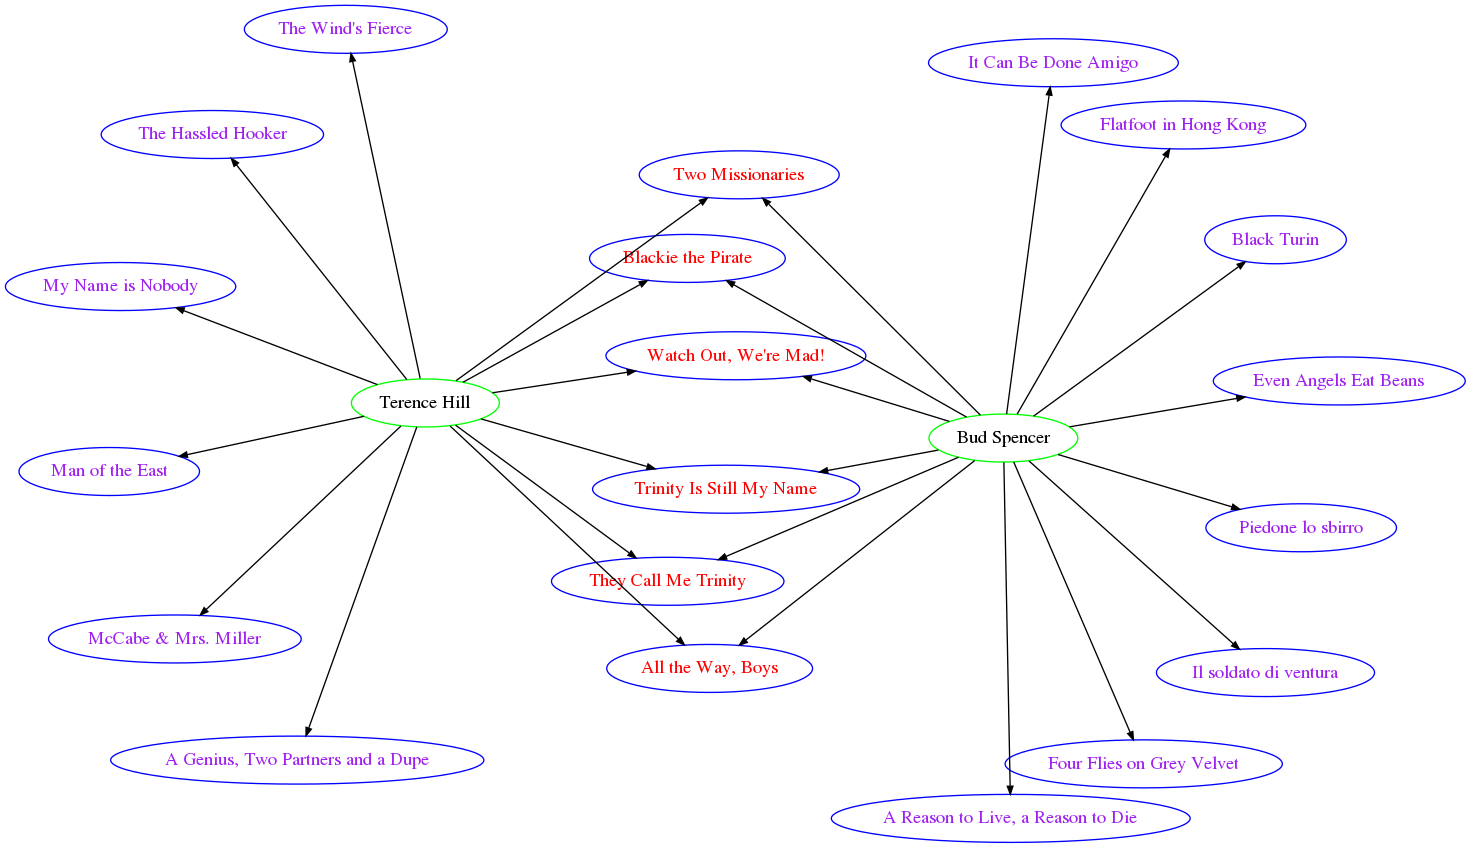

In [69]:
import networkx as nx
from sciprog import draw_nx

def show_graph(movies, since_year, until_year, language):
    G = nx.DiGraph()       
    G.graph['graph']= { 'layout':'neato' }  # don't delete these!
    
    extracted_actors = []
    for movie in movies:
        for actor in movies[movie]["actors"]:
            if actor[1] not in extracted_actors:
                extracted_actors.append(actor[1])
  
    i = 1
    for actor in extracted_actors:
        
        G.add_node(actor, fillcolor="orange", color='green', fontcolor='black')
        i += 1
        
    for movie in movies:
    
        if movies[movie]['first_release'][0] >= since_year and movies[movie]['first_release'][0] <= until_year:
            name_this_language = movies[movie]['names'][language]
            if len(movies[movie]['actors']) > 1:
                color = "red"
            else:
                color = "purple"
            G.add_node(name_this_language, fontcolor = color)
            
            for act in movies[movie]['actors']:
                if act[1] in extracted_actors:
                    G.add_edge(act[1], name_this_language)
    
    draw_nx(G)
    
            
    
    
show_graph(movies_db, 1970, 1975, 'en')    

In [10]:
#show_graph(movies_db, 1970, 1974, 'it')